<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:


- **TransactionID:** Identificador único alfanumérico para cada transacción.

- **AccountID:** Identificador único de la cuenta asociada a la transacción.

- **TransactionAmount:** Monto de la transacción.

- **TransactionDate:** Fecha y hora de la transacción.

- **TransactionType:** Tipo de transacción (Crédito o Débito).

- **Location:** Ubicación geográfica donde ocurrió la transacción.

- **DeviceID:** Identificador del dispositivo usado para la transacción.

- **IP Address:** Dirección IP asociada a la transacción, que puede cambiar ocasionalmente para algunas cuentas.

- **MerchantID:** Identificador único para los comercios, mostrando tanto comerciantes preferidos como atípicos para cada cuenta.

- **AccountBalance:** Saldo restante en la cuenta después de la transacción.

- **PreviousTransactionDate:** Fecha y hora de la transacción anterior en la cuenta.

- **Channel:** Canal utilizado para realizar la transacción (en línea, sucursal, cajero automático, etc.).

- **CustomerAge:** Edad del titular de la cuenta.

- **CustomerOccupation:** Ocupación del titular de la cuenta (por ejemplo, Doctor, Ingeniero, Estudiante, Jubilado), reflejando patrones de ingresos.

- **TransactionDuration:** Duración de la transacción en segundos.

- **LoginAttempts:** Número de intentos de inicio de sesión antes de realizar la transacción.

- **TransactionStatus:** Variable objetivo que indica si la transacción es "Normal" o "Anómala".


# 0. Imports

## 0.1 Import functions and packages

In [79]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl

# Mathematical functions
# -----------------------------------------------------------------------
import math


# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.data_visualization_support as dvs
import category_encoders as ce


# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr

# Scikit-learn transformers
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0.1 Load dataset

In [80]:
financial_df = pd.read_csv("../datos/financial_data.csv")
financial_df.info()
financial_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035


The dataset at hand consists of 10.000 rows and 11 columns.

# 1. Preliminary analysis and cleaning

Prior to a proper EDA, it is necessary to look for errors in data types, typos, missing values, or any other characteristic that would need correction.

During import, ceratin columns where identified to have incorrect data types:

**Data types**
- transaction_id, customer_id and merchant_id are int type, but should be categorical as the are ids.
- transaction_time is of object type but could be converted to datetime

In [81]:
financial_df[["transaction_id", "customer_id", "merchant_id"]] = financial_df[["transaction_id", "customer_id", "merchant_id"]].astype("object")

financial_df["transaction_time"] = pd.to_datetime(financial_df["transaction_time"])

Let's output a concise exploration:

In [82]:
# exploration
se.exploracion_dataframe(financial_df)

El número de datos es 10000 y el de columnas es 11

 ..................... 

Las primeras filas del dataframe son:


,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053



 ..................... 

Los tipos de las columnas son:


,tipo_dato
transaction_id,object
customer_id,object
merchant_id,object
amount,float64
transaction_time,datetime64[ns]
is_fraudulent,int64
card_type,object
location,object
purchase_category,object
customer_age,int64



 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TRANSACTION_ID tiene 10000 valores únicos, de los cuales los primeros son:


,count,pct
transaction_id,,
9984,1,0.0
9983,1,0.0
9982,1,0.0
9981,1,0.0
9980,1,0.0


La columna CUSTOMER_ID tiene 100 valores únicos, de los cuales los primeros son:


,count,pct
customer_id,,
1074,126,1.3
1085,120,1.2
1059,118,1.2
1018,116,1.2
1099,116,1.2


La columna MERCHANT_ID tiene 100 valores únicos, de los cuales los primeros son:


,count,pct
merchant_id,,
2016,120,1.2
2078,120,1.2
2055,118,1.2
2019,117,1.2
2057,117,1.2


La columna CARD_TYPE tiene 4 valores únicos, de los cuales los primeros son:


,count,pct
card_type,,
Discover,2633,26.3
American Express,2494,24.9
Visa,2490,24.9
MasterCard,2383,23.8


La columna LOCATION tiene 50 valores únicos, de los cuales los primeros son:


,count,pct
location,,
City-7,223,2.2
City-40,221,2.2
City-14,218,2.2
City-32,218,2.2
City-41,218,2.2


La columna PURCHASE_CATEGORY tiene 6 valores únicos, de los cuales los primeros son:


,count,pct
purchase_category,,
Travel,1694,16.9
Groceries,1692,16.9
Gas Station,1666,16.7
Retail,1661,16.6
Online Shopping,1651,16.5


La columna TRANSACTION_DESCRIPTION tiene 100 valores únicos, de los cuales los primeros son:


,count,pct
transaction_description,,
Purchase at Merchant-2016,120,1.2
Purchase at Merchant-2078,120,1.2
Purchase at Merchant-2055,118,1.2
Purchase at Merchant-2019,117,1.2
Purchase at Merchant-2057,117,1.2


From this quick exploration, the following is observed:

**Data types**

Corrected above.

**Duplicates**

No duplicates accross all columns are found.

**Missing**

No missing values present in the dataset.

**Typos**

No typos are identified straight away from the exploration.

Additionally, it is observed that there are 10.000 rows, one for each unique transaction, but they belong to just 100 customers and merchants. These transactions are performed with just 4 different types of card_types, for 6 different purchase_categories and in 50 different cities.

Let's check wether these unique 100 customers and merchants are combined or paired:

In [83]:
print(f"The 100 unique customer_ids an merchant_ids are combined into {len(financial_df[['merchant_id','customer_id']].value_counts())}")

The 100 unique customer_ids an merchant_ids are combined into 6286


The column description looks like is basically repeating the information from the merchant_id:

In [84]:
regex_pattern = r"Purchase at Merchant-\d{4}" 
financial_df[financial_df["transaction_description"].str.contains(regex_pattern, regex=True)].shape[0]

10000

It is indeed always just adding 'Purchase at Merchant-' to the merchant_id, so dropping:

In [85]:
financial_df.drop(columns=["transaction_description","transaction_id"],inplace=True)

Now, let's check numerical features for abnormal values or ranges.

In [86]:
financial_df.describe().T

,count,mean,min,25%,50%,75%,max,std
amount,10000.0,4958.381617,10.61,2438.175,4943.945,7499.3125,9999.75,2899.699675
transaction_time,10000,2023-01-01 01:23:19.500000256,2023-01-01 00:00:00,2023-01-01 00:41:39.750000128,2023-01-01 01:23:19.500000,2023-01-01 02:04:59.249999872,2023-01-01 02:46:39,NaN
is_fraudulent,10000.0,0.5068,0.0,0.0,1.0,1.0,1.0,0.499979
customer_age,10000.0,44.0475,18.0,31.0,44.0,57.0,70.0,15.321707


- Amounts: Looks like they have a normal range. Mean and median fall coincide. We will look at the distribution more closely during EDA.
- is_fraudulent: 50% of transactions are fradulent. Ranges look healthy.
- customer_age: No abnormal values are inferred.

Is_fraudulent is the target feature, which is binary. Thus, it should be changed to object:

In [87]:
financial_df["is_fraudulent"] = financial_df["is_fraudulent"].astype("object")

# 2. EDA

## 2.1 Univariate

## 2.1.1 Target feature - is_fraudulent

Although the perfect balance in the target feature, is_fraudulent, was observed in the preliminary analysis, let's plot the counts to illustrate it best.

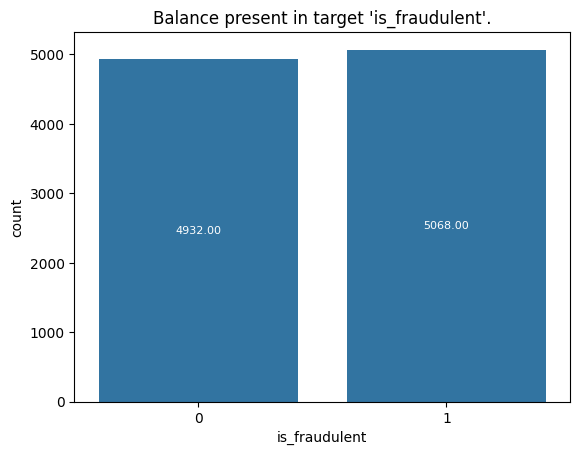

In [88]:
plt.title("Balance present in target 'is_fraudulent'.")

ax = sns.countplot(data=financial_df,
              x="is_fraudulent")
dvs.plot_bar_labels(ax)

## 2.1.2 Numerical features

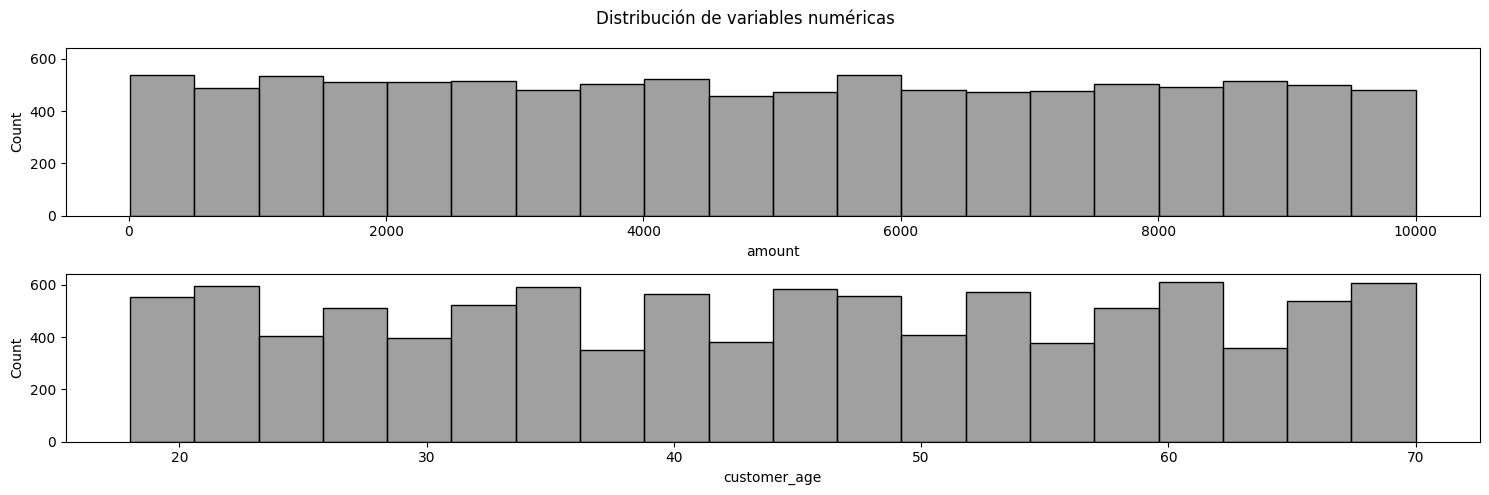

In [89]:
visualizador = sp.Visualizador(financial_df.drop(columns=["transaction_time"]))

visualizador.plot_numericas()

Distributions are seemingly uniform for both amount and customer_age, when inspected univariatedly.

## 2.1.3 Categorical features

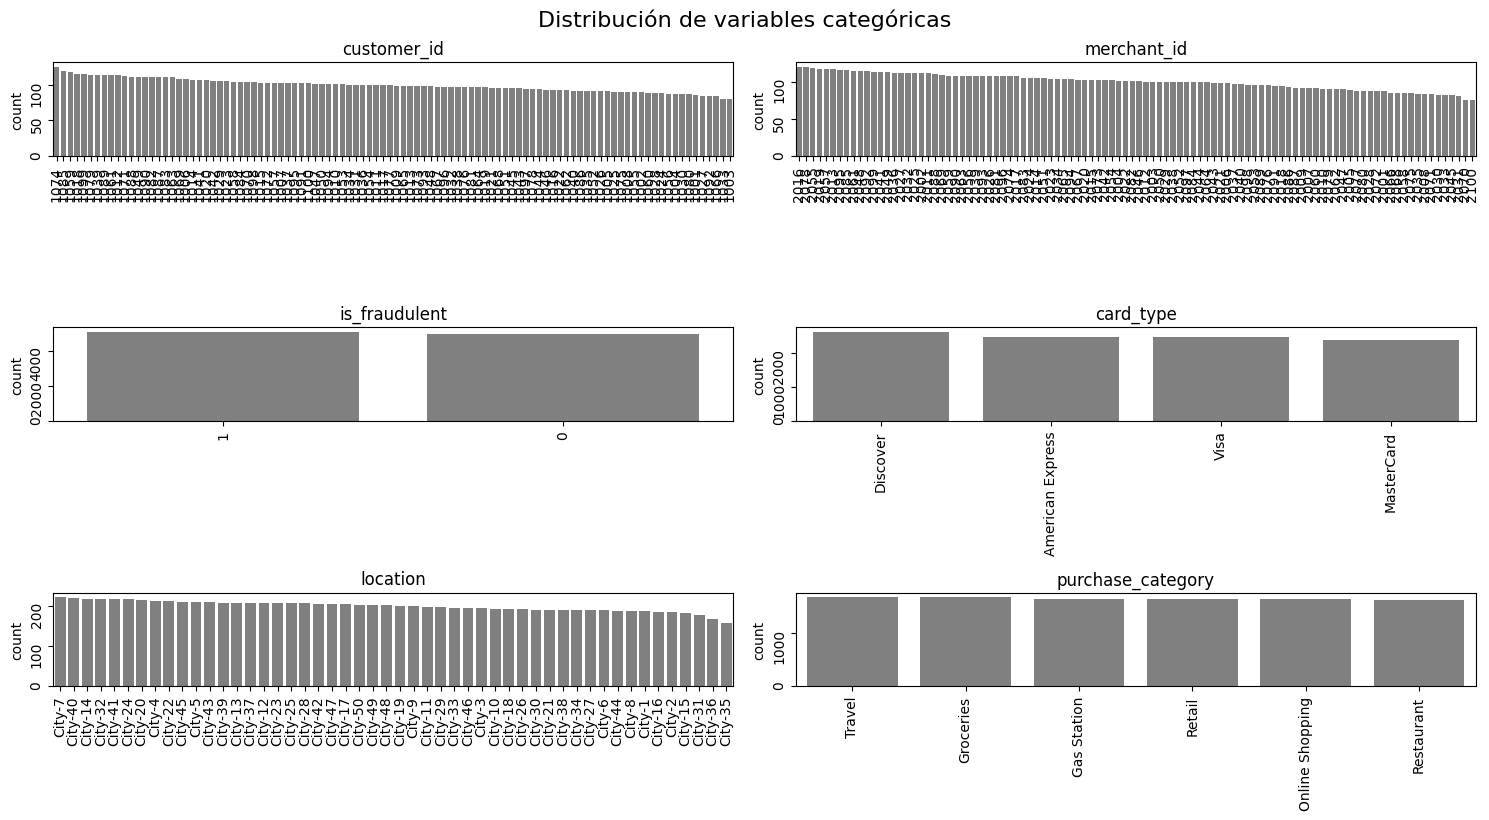

In [90]:
visualizador.plot_categoricas(tamano_grafica=(15,8))

Customer_id and merchand_id both follow similar count distributions, with very equal increments/decrements. Locations also follow very continuous increments/decrements of transaction counts across cities.

Frequency counts for different card_types are just slighly different, 'Discover' being the most used one.

Finally, purchase categories show no difference in frequency.

## 2.2 Multivariate

### 2.2.1 Target with respect to others:

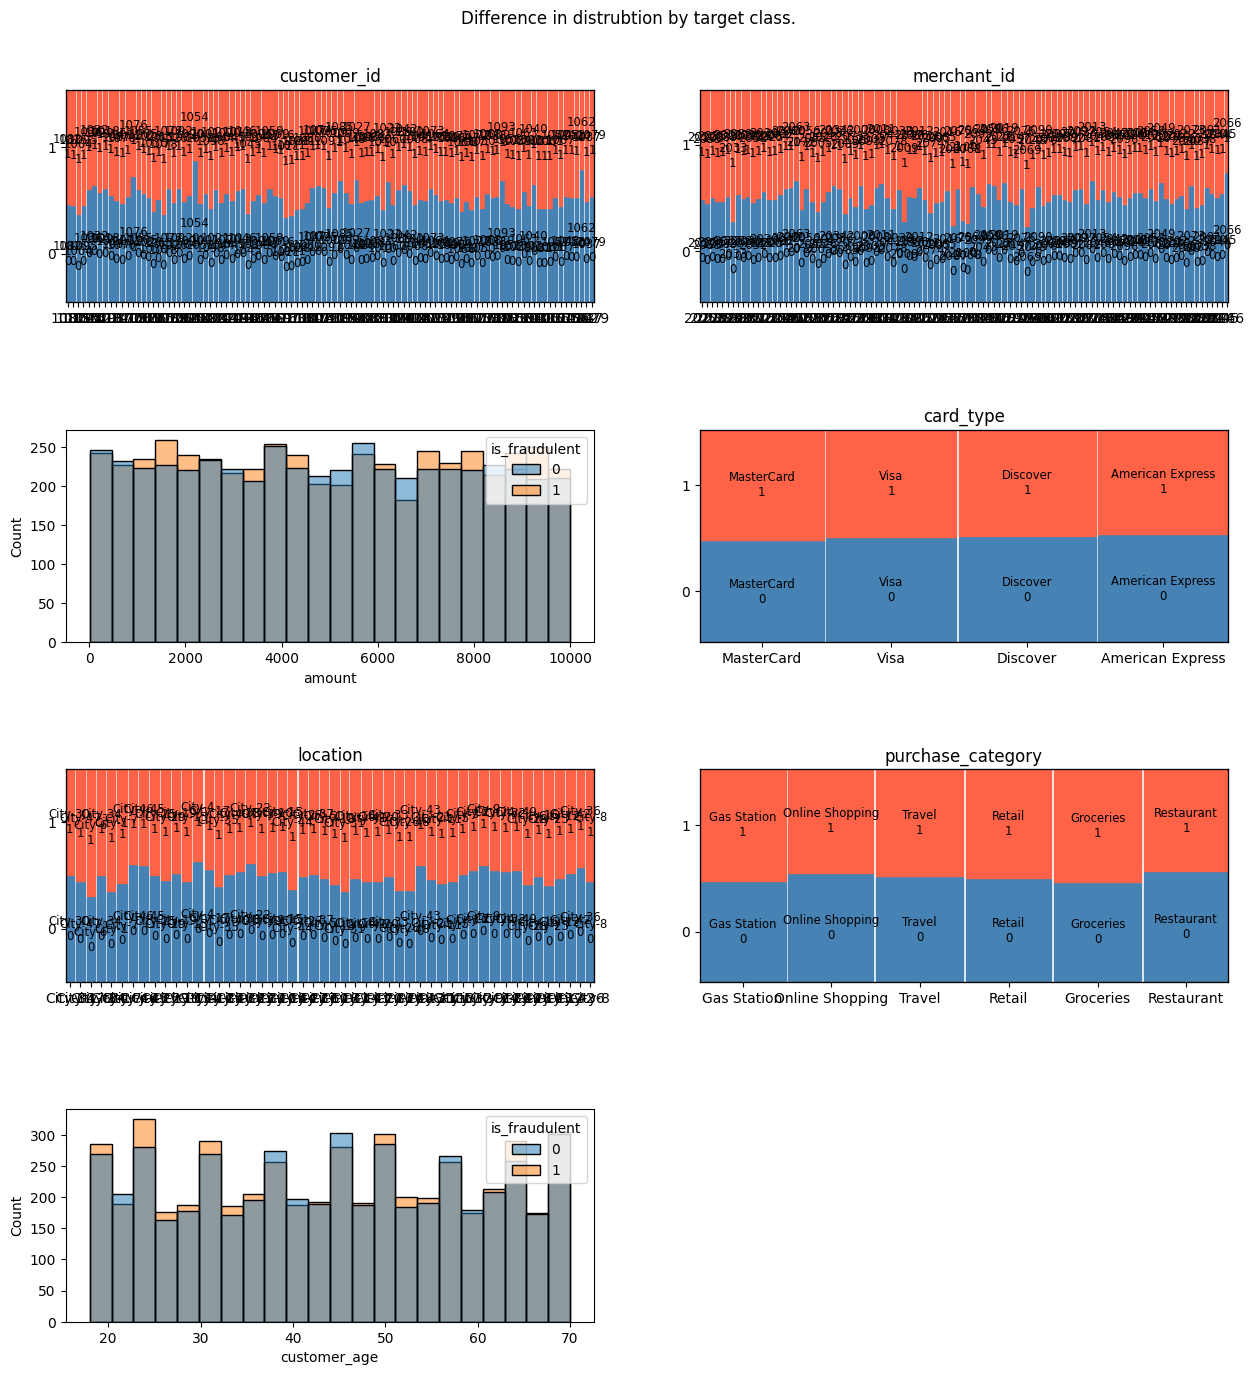

In [91]:
color_mapping = {
    "0": "#4682B4",  # Light Blue (Pastel Blue)
    "1": "#FF6347"  # Light Pink (Pastel Red)
}

se.plot_relationships_categorical_target(financial_df.drop(columns=["transaction_time"]), "is_fraudulent", cat_type="mosaic", mapping=color_mapping)

From the plots above, it seems there are not visually significant differences for the ditribution of customer age or amount for the transtaction for transactions that are fraudulent Vs. non-fraudulent.

Similarly, for the categorical features, there are no visually significant differences among types of cards, and just slightly more for purchase type.

Although with smaller sample sizes, there are more significant differences among locations and among customer_ids and merchant_ids.

Maybe it is interesting to see if customer_ids and merchant_ids have transactions in different cities and if that influences the fraud flag.

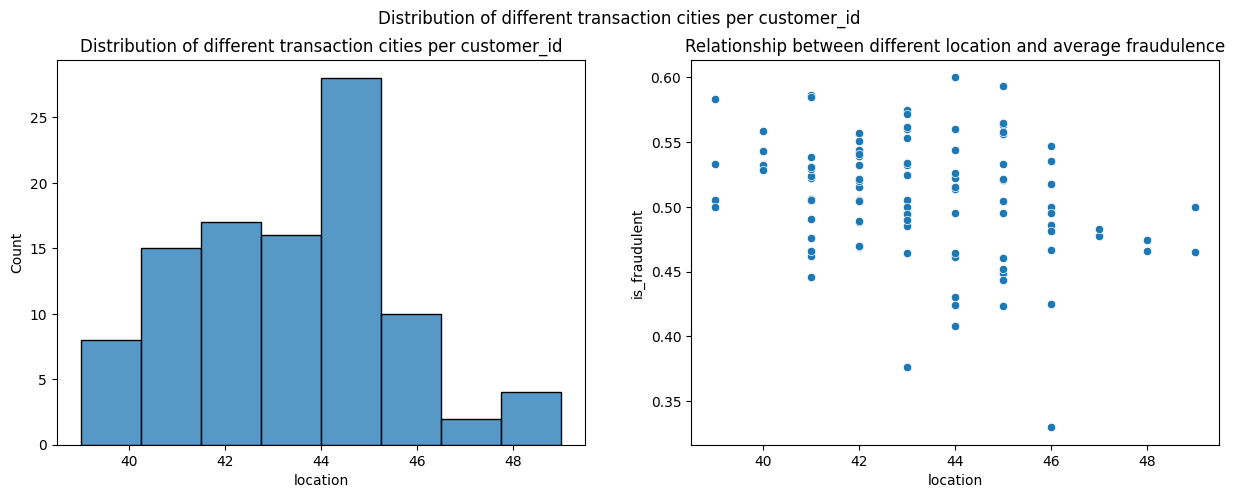

In [92]:
# calculate different cities per customer
cities_count_by_customer = (financial_df[["customer_id","location"]].value_counts().reset_index()
.groupby("customer_id")[["location"]].count())

# calculate fraud % by customer and join
cities_vs_fraud = pd.concat([cities_count_by_customer,financial_df.groupby("customer_id")[["is_fraudulent"]].mean()],axis=1)



# plot both the distribution and relationship
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.flat

plt.suptitle("Distribution of different transaction cities per customer_id")

axes[0].set_title("Distribution of different transaction cities per customer_id")
sns.histplot(data=cities_count_by_customer,
             x="location",
             ax=axes[0])

axes[1].set_title("Relationship between different location and average fraudulence")
sns.scatterplot(data=cities_vs_fraud,
                x="location",
                y="is_fraudulent",
                ax=axes[1])

plt.show()

The minimum amount of different locations is around 40, which is very unusual. There is also a slight negative correlation, which does not mean causation, between the proportion of fraudulent transactions and location.

### 2.2.2 Numerical vs. numerical

There are just 2 numerical columns that could show relationships between them:

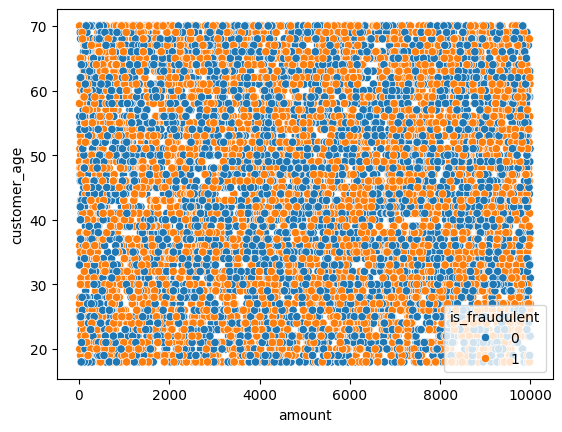

In [93]:
sns.scatterplot(data=financial_df[["amount","customer_age","is_fraudulent"]],
                x="amount",
                y="customer_age",
                hue="is_fraudulent")
plt.show()

There are obviously no relationships between the features.

### 2.2.2 target vs. time

The range in time for the dataset is quite narrow. However, there might be a pattern in it.

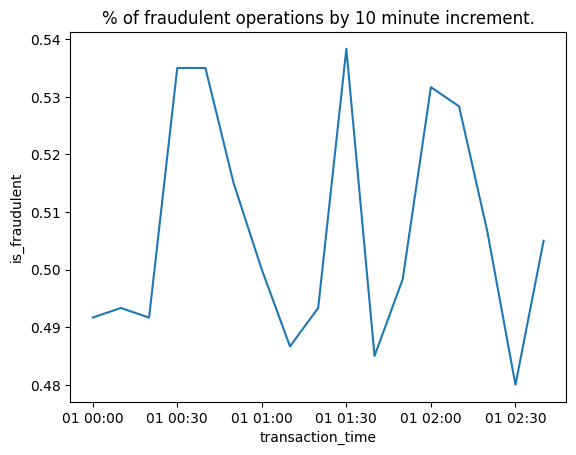

In [106]:
financial_time = financial_df.set_index('transaction_time')

# Resample by 10-minute intervals and sum the 'amount'
resampled_df = financial_time.resample('10T')["is_fraudulent"].mean()
plt.title("% of fraudulent operations by 10 minute increment.")
sns.lineplot(resampled_df)
plt.show()

There is a fluctuation of fraudulent operations, but the time window is so small, that it is difficult to affirm that the oscillation is not due to some randomness, or at least, it is difficult to justify it.

For now, let's drop it but keep it in mind as a possible feature for the model.

In [107]:
financial_df.drop(columns=["transaction_time"],inplace=True)

# 3. Transformations

## 3.1 Missing values

There is no need for missing value treatment, as the are no missings in the dataset.

## 3.2 Outliers

Empecemos por visualizar los outliers univariados.

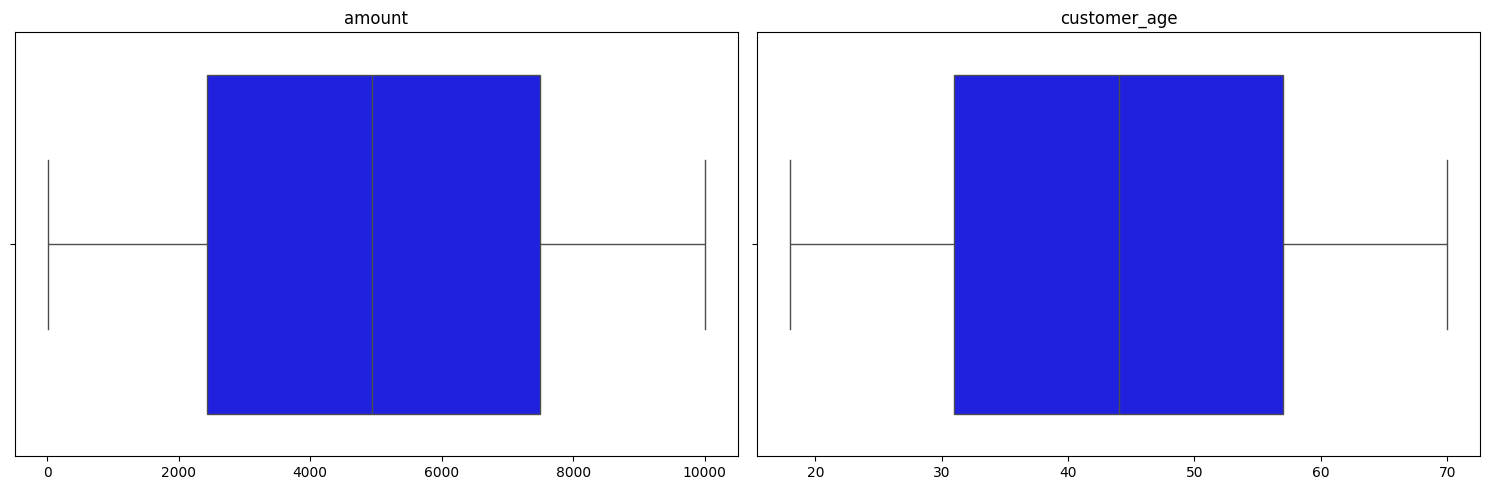

In [94]:
import src.soporte_outliers as so

visualizador = so.GestionOutliersUnivariados(financial_df)

visualizador.visualizar_outliers_univariados(tamano_grafica=(15,5))

Judging by the boxplots, there are no univariate outliers beyond the range of 1.5 IQR below Q1 or above Q3.

Given the relationship between the numerical variables themselves and with the target variable is not deemed necessary to use multivariate methods. If the resulting model does not yield enough performance, then this exploration will be revisited to identify multivariate outliers.

## 3.3 Encodings

The chi-squared test of independance is performed, to assess whether to there are significant differences among the groups.

In [95]:
for columna_grupo in financial_df.drop(columns=["transaction_time"]).select_dtypes("O"):
    print(f"Testeando {columna_grupo}")
    tester = sen.AnalisisChiCuadrado(financial_df, columna_grupo, "is_fraudulent")

    tester.generar_tabla_contingencia()

    tester.realizar_prueba_chi_cuadrado()
    print("\n-----")


Testeando customer_id
Tabla de contingencia:


customer_id,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
is_fraudulent,,,,,,,,,,,,,,,,,,,,,
0,44,45,37,36,47,55,45,42,51,44,...,46,45,57,48,47,46,45,46,60,54
1,42,45,44,51,45,53,58,49,48,57,...,57,39,42,54,56,52,50,58,56,49



Resultado de la prueba de Chi-cuadrado:
Chi2: 86.94701595743726, p-valor: 0.8012597537846581
El p-valor >= 0.05, no hay diferencias entre los grupos.

-----
Testeando merchant_id
Tabla de contingencia:


merchant_id,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
is_fraudulent,,,,,,,,,,,,,,,,,,,,,
0,45,59,46,49,38,54,46,45,35,46,...,51,58,47,49,54,59,53,44,58,29
1,42,52,54,52,51,44,45,38,57,44,...,43,56,60,54,61,48,46,52,55,46



Resultado de la prueba de Chi-cuadrado:
Chi2: 91.50030498460147, p-valor: 0.6912371762337383
El p-valor >= 0.05, no hay diferencias entre los grupos.

-----
Testeando is_fraudulent
Tabla de contingencia:


is_fraudulent,0,1
is_fraudulent,,
0,4932,0
1,0,5068



Resultado de la prueba de Chi-cuadrado:
Chi2: 9995.999660171145, p-valor: 0.0
El p-valor < 0.05, parece que hay diferencias entre los grupos.

-----
Testeando card_type
Tabla de contingencia:


card_type,American Express,Discover,MasterCard,Visa
is_fraudulent,,,,
0,1262,1304,1140,1226
1,1232,1329,1243,1264



Resultado de la prueba de Chi-cuadrado:
Chi2: 3.7812082706660246, p-valor: 0.28607950351317196
El p-valor >= 0.05, no hay diferencias entre los grupos.

-----
Testeando location
Tabla de contingencia:


location,City-1,City-10,City-11,City-12,City-13,City-14,City-15,City-16,City-17,City-18,...,City-46,City-47,City-48,City-49,City-5,City-50,City-6,City-7,City-8,City-9
is_fraudulent,,,,,,,,,,,,,,,,,,,,,
0,80,100,92,102,99,106,96,92,109,89,...,108,97,87,106,99,98,76,103,89,110
1,108,94,107,107,110,112,88,94,96,105,...,88,109,115,96,111,104,114,120,99,90



Resultado de la prueba de Chi-cuadrado:
Chi2: 57.82620144183307, p-valor: 0.18154121719730704
El p-valor >= 0.05, no hay diferencias entre los grupos.

-----
Testeando purchase_category
Tabla de contingencia:


purchase_category,Gas Station,Groceries,Online Shopping,Restaurant,Retail,Travel
is_fraudulent,,,,,,
0,792,796,847,851,808,838
1,874,896,804,785,853,856



Resultado de la prueba de Chi-cuadrado:
Chi2: 13.291965751690256, p-valor: 0.020791075460818598
El p-valor < 0.05, parece que hay diferencias entre los grupos.

-----


There’s only one variable with significant differences between groups: purchase_category. The decision for encoding this variable is to use target encoding, as it models the observable relationship with the target variable more accurately than frequency or ordinal encoding.

For others, there are no significant differences. Card_type can be tested with one-hot encoding, as dimensionality in the dataset is not an issue with 9 usable features and 10k rows. For the remaining, customer_id, merchant_id and location, the logical thing would be to drop them, or group them for encoding. However, as a first iteration it is less complex to target encode them all and assess results. 

In [98]:
target = ce.TargetEncoder()

# convert target feature into numeric type
financial_df["is_fraudulent"] = financial_df["is_fraudulent"].astype(int)

# convert encoding categories to 
financial_df[["purchase_category","location","customer_id","merchant_id"]] = financial_df[["purchase_category","location",
                                                                                           "customer_id","merchant_id"]].astype("category")



targets_transformed = target.fit_transform(financial_df[["purchase_category", 
                                                         "location","customer_id","merchant_id"]], y=financial_df["is_fraudulent"])


financial_df[["purchase_category_target","location_target",
              "customer_id_target","merchant_id_target"]] = targets_transformed

# drop original columns
financial_df.drop(columns=["purchase_category","location","customer_id","merchant_id"],inplace=True)


# one-hot for card_type
one_hot = OneHotEncoder(sparse_output=False)

card_type_one_hot = pd.DataFrame(one_hot.fit_transform(financial_df[["card_type"]]), columns=one_hot.get_feature_names_out())

# drop original columns
financial_df.drop(columns=["card_type"], inplace=True)

financial_df = pd.concat([financial_df, card_type_one_hot],axis=1)


## 3.4 Feature scaling

The method of choice for feature scaling, given that there are no apparent outliers, we can apply MinMax Scaling to try and improve model convergence.

In [110]:
scaler = MinMaxScaler()

X = financial_df.loc[:, financial_df.columns != 'is_fraudulent']

financial_df.loc[:, financial_df.columns != 'is_fraudulent'] = scaler.fit_transform(X)
financial_df.head()

,amount,is_fraudulent,customer_age,purchase_category_target,location_target,customer_id_target,merchant_id_target,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
0,0.575423,0,0.480769,0.900628,0.389453,0.779808,0.510079,0.0,0.0,1.0,0.0
1,0.189301,1,0.826923,0.143774,0.578321,0.791454,0.584829,0.0,0.0,0.0,1.0
2,0.123960,1,0.750000,0.900628,1.000000,0.948651,0.463460,0.0,0.0,1.0,0.0
3,0.761671,1,0.788462,0.512530,1.000000,0.791454,0.541243,0.0,1.0,0.0,0.0
4,0.188153,1,0.346154,0.678115,0.389453,0.518519,0.533525,0.0,0.0,1.0,0.0


Now we can save this dataframe to use it in the next phase:

In [111]:
financial_df.to_csv("../datos/financial_df_preprocesado.csv")